# Herron Topic 3 - Practice - Sec 03

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. Projects:
    1. Project 1:
        1. I am still grading
        2. I plan to finish grading by Friday
    2. Project 2:
        1. Due on Friday, 3/28, at 11:59 PM
        2. We will use class time next week for group work
        3. Ask your questions here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2738173>
2. Assessments:
    1. ***Both assessments are in class on Tuesday, 4/15***
    2. Programming assessment: Should take 15 minutes and will be based on the questions here:
    3. MSFQ assessment (only for MSFQ students): Should take 45 minutes and based on the 5 required MSFQ courses (standby for a Canvas announcement with more details after I discuss it with the MSFQ program director)

## Five-Minute Review

Quantitative value investing is a systematic investment strategy that combines the principles of value investing with data-driven, quantitative techniques.
It involves identifying undervalued securities---those trading below their intrinsic value---using predefined, measurable criteria rather than subjective judgment.
Common criteria are price/earnings (P/E) and price/book (P/B) ratios.
Here, we will use the book-to-market equity ratio (B/M), which is common in the academic literature and quantitative investing.

The key concepts in this topic are creating metrics, forming portfolios, and backtesting the strategy.

##  Practice

### Re-implement the value strategy from the lecture notebook

#### Read the data

This code reads stock market data from a file called `crsp.csv` and prepares it for analysis.
It loads the data into a data frame, makes sure the dates are in the right format, and marks certain letters (`A`, `B`, and `C`) as missing values.
Then, it filters the data to include only records from 1965 or later, sorts it by company and date, and adds two new columns: one for market equity (calculated as the number of shares times the stock price, converted to millions), and another to adjust all dates to the end of each month.

In [3]:
crsp = (
    pd.read_csv(
        filepath_or_buffer='crsp.csv',  # Read data from crsp.csv file
        parse_dates=['date'],           # Convert 'date' column to datetime format
        na_values=['A', 'B', 'C']       # Treat 'A', 'B', 'C' as missing values (NaN)
    )
    .query('date >= 1965')              # Filter to keep only data from 1965 onward
    .sort_values(['PERMNO', 'date'])    # Sort by company identifier (PERMNO) and date
    .assign(
        ME=lambda x: x['SHROUT'] * x['PRC'].abs() / 1_000,  # Calculate market equity (ME) as shares outstanding * absolute price / 1000
        date=lambda x: x['date'] + pd.offsets.MonthEnd(0)   # Adjust dates to the last day of each month
    )
)

In [4]:
crsp.head()

,PERMNO,date,SHRCD,PRC,RET,SHROUT,ME
0,10000,1986-01-31,10,-4.3750,NaN,3680.0000,16.1000
1,10000,1986-02-28,10,-3.2500,-0.2571,3680.0000,11.9600
2,10000,1986-03-31,10,-4.4375,0.3654,3680.0000,16.3300
3,10000,1986-04-30,10,-4.0000,-0.0986,3793.0000,15.1720
4,10000,1986-05-31,10,-3.1094,-0.2227,3793.0000,11.7939


This code brings in financial data from a file named `compustat.csv` and prepares it for analysis.
It loads the data into a data frame, formats dates, and filters out any records before 1965.
Then, it sorts the data by company, fiscal year, and date.
Finally, it removes any duplicate entries for the same company and fiscal year, keeping only the most recent record.

In [5]:
compustat = (
    pd.read_csv(
        filepath_or_buffer='compustat.csv',  # Read data from compustat.csv file
        parse_dates=['datadate']              # Convert 'datadate' column to datetime format
    )
    .query('datadate >= 1965')                # Filter to keep only data from 1965 onward
    .sort_values(['LPERMNO', 'fyear', 'datadate'])  # Sort by company identifier (LPERMNO), fiscal year, and date
    .drop_duplicates(subset=['LPERMNO', 'fyear'], keep='last')  # Keep only the latest record per company and fiscal year
)

In [6]:
compustat.head()

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,ib,costat
165681,13007,10000,1986-10-31,1986.0000,INDL,C,D,STD,USD,0.4180,-0.7300,I
165586,12994,10001,1986-06-30,1986.0000,INDL,C,D,STD,USD,5.4320,0.6690,I
165587,12994,10001,1987-06-30,1987.0000,INDL,C,D,STD,USD,5.3690,0.3120,I
165588,12994,10001,1988-06-30,1988.0000,INDL,C,D,STD,USD,5.5120,0.5420,I
165589,12994,10001,1989-06-30,1989.0000,INDL,C,D,STD,USD,6.3210,1.2080,I


About 64 percent of firm-years have December fiscal-year ends.

In [7]:
compustat['datadate'].dt.month.value_counts() / compustat['datadate'].shape[0]

datadate
12   0.6401
6    0.0723
9    0.0609
3    0.0518
10   0.0341
1    0.0334
8    0.0203
7    0.0187
5    0.0187
4    0.0179
11   0.0173
2    0.0146
Name: count, dtype: float64

#### Create the interim data frames

This code finds the market value of equity (`ME`) as of December each year from the `crsp` data frame (to match with book value of equity `ceq` from the `compustat` data frame below).
It filters out any rows where market equity is zero or negative, then sorts the data by company and date.
Next, it groups the data by company and year, focusing on December values.
Finally, it selects the last market equity value for each company in each year, giving us the December `ME`.

In [8]:
mve = (
    crsp
    .query('ME > 0')                            # Filter for positive market equity values
    .sort_values(['PERMNO', 'date'])            # Sort by company identifier (PERMNO) and date
    .groupby(by=['PERMNO', pd.Grouper(key='date', freq='YE-DEC')])  # Group by company and year-end December
    [['ME']]                                    # Select the market equity (ME) column
    .last()                                     # Take the last ME value for each group (December value)
)

In [9]:
mve.head()

ME
PERMNO date             
10000  1986-12-31 1.9816
       1987-12-31 0.8516
10001  1986-12-31 6.9370
       1987-12-31 5.8280
       1988-12-31 6.3623

This code finds the book value of equity (`ceq`) as of December each year from the `compustat` data frame.
It filters out any rows where common equity is zero or negative, then sorts the data by company and date.
Next, it groups the data by company and year, focusing on December values.
Finally, it selects the last common equity value for each company in each year, giving us the December `ceq`.

In [10]:
bve = (
    compustat
    .query('ceq > 0')                            # Filter for positive common equity values
    .sort_values(['LPERMNO', 'datadate'])        # Sort by company identifier (LPERMNO) and date
    .groupby(by=['LPERMNO', pd.Grouper(key='datadate', freq='YE-DEC')])  # Group by company and year-end December
    [['ceq']]                                    # Select the common equity (ceq) column
    .last()                                      # Take the last CEQ value for each group (December value)
)

In [11]:
bve.head()

ceq
LPERMNO datadate         
10000   1986-12-31 0.4180
10001   1986-12-31 5.4320
        1987-12-31 5.3690
        1988-12-31 5.5120
        1989-12-31 6.3210

#### Combine the data frames and form portfolios

This code shows a simple example of how to form portfolios using the `pd.qcut()` function.
It takes a sequence of numbers from 0 to 9 and splits them into 2 equal groups (quantiles), assigning them to either a low or high category.
The `labels=False` argument gives us numeric group identifiers (0 or 1), and adding 1 shifts these to 1 or 2, which can represent portfolio numbers.

In [12]:
1 + pd.qcut(x=np.arange(10), q=2, labels=False)

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

::: {.callout-note}

In class, in the following cell, I used multiple cursors to simultaneously type two `.rename_axis(index=['PERMNO', 'Date'])` methods.
If you hold down the `CTRL` key, every mouse click will generate a new cursor.
Each cursor will do the same action (e.g., typing, highlighting, and deleting).
More [here](https://discourse.jupyter.org/t/most-useful-keyboard-shortcuts-for-notebook-lab/18113).

:::

This code creates portfolios based on book-to-market (`BM`) ratios using the `bve` and `mve` data frames.
It starts by aligning the company and date indexes of both datasets and merges them, keeping only rows with matching data.
Next, it calculates the `BM` ratio by dividing book value of equity (`ceq`) by market value of equity (`ME`).
After resetting the index, it shifts the dates forward by 7 months to time the portfolio formation correctly, giving 6 months between `BM` calculation and buying stocks at the end of June to receive July returns.
Finally, for each date, it sorts the `BM` ratios into 10 equal groups (deciles) and assigns portfolio numbers from 1 to 10.

In [13]:
bm = (
    bve
    .rename_axis(index=['PERMNO', 'Date'])  # Standardize index names to PERMNO (company ID) and Date for merging
    .join(
        other=mve.rename_axis(index=['PERMNO', 'Date']),  # Combine with market equity data, matching on company and date
        how='inner'                               # Use inner join to retain only records with both book and market data
    )
    .reset_index()                                # Flatten the index into columns for easier manipulation
    .assign(
        Date=lambda x: x['Date'] + pd.offsets.MonthEnd(7),  # Shift dates forward 7 months (to June-end) for portfolio timing
        BM=lambda x: x['ceq'] / x['ME'],                  # Compute book-to-market ratio as common equity over market equity
        Portfolio=lambda x: x.groupby('Date')['BM'].transform(  # Assign stocks to portfolios based on BM deciles
            lambda x: 1 + pd.qcut(x=x, q=10, labels=False)  # Divide BM into 10 quantiles (0-9), shift to 1-10 for portfolio IDs
        )
    )
)

In [14]:
bm.head()

,PERMNO,Date,ceq,ME,BM,Portfolio
0,10000,1987-07-31,0.4180,1.9816,0.2109,2
1,10001,1987-07-31,5.4320,6.9370,0.7830,7
2,10001,1988-07-31,5.3690,5.8280,0.9212,7
3,10001,1989-07-31,5.5120,6.3623,0.8664,7
4,10001,1990-07-31,6.3210,10.3477,0.6109,5


This code creates a bar chart showing the average book-to-market (`BM`) ratio for each portfolio using the `portfolios` data frame.
It groups the data by portfolio number (1 to 10), calculates the mean `BM` ratio for each group, and then plots these averages as bars.
As expected, we see that `BM` rises from portfolio 1 to 10.

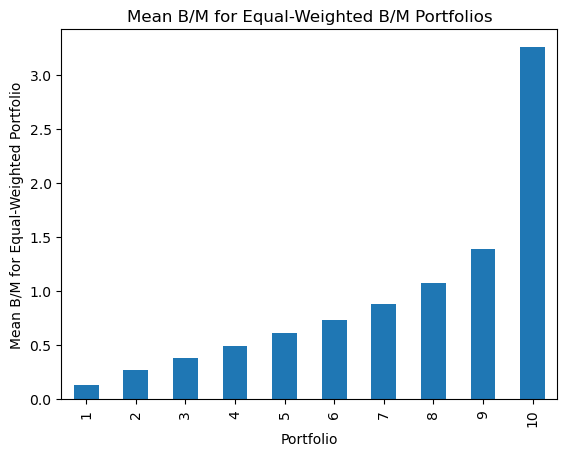

In [15]:
(
    bm
    .groupby(by=['Portfolio', 'Date'])  # Group data by portfolio number and date
    ['BM']                              # Select the book-to-market (BM) column
    .mean()                             # Calculate the mean BM for each portfolio-date combination
    .groupby(by='Portfolio')            # Group again by portfolio to average across all dates
    .mean()                             # Calculate the time-averaged mean BM for each portfolio
    .plot(kind='bar')                   # Plot the results as a bar chart
)
plt.ylabel('Mean B/M for Equal-Weighted Portfolio')
plt.title('Mean B/M for Equal-Weighted B/M Portfolios')
plt.show()

This code combines monthly stock returns from the `crsp` data frame with the _most recent_ portfolio assignments from the `bm` data frame.
The `tolerance` argument tells the merge to only use portfolio assignments within 366 days to avoid stale data.

In [16]:
stocks = (
    pd.merge_asof(
        left=crsp.sort_values(['date', 'PERMNO']),    # Sort CRSP data by date and company ID for time-based merging
        right=bm.sort_values(['Date', 'PERMNO']),     # Sort BM data by date and company ID to align with returns
        left_on='date',                               # Match CRSP dates to the closest prior BM date
        right_on='Date',                              # Use BM dates as the reference for the merge
        by='PERMNO',                                  # Merge on company ID (PERMNO) to link same stocks
        tolerance=pd.Timedelta('366d')                # Limit matches to portfolio assignments within 366 days
    )
    [['PERMNO', 'date', 'Portfolio', 'RET']]          # Select key columns: company ID, date, portfolio, and returns
    .dropna()                                         # Remove rows with missing values (e.g., unmatched returns)
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int))  # Convert portfolio numbers to integers for clarity
    .rename(columns={'date': 'Date'})                 # Rename 'date' column to 'Date' for consistency
)

This code creates equal-weighted portfolios using the `stocks` data frame.
It groups the data by portfolio number (`Portfolio`) and date (`Date`), then calculates the mean return (`RET`) for each group.
This averaging process gives each stock within a portfolio the same weight, producing equal-weighted portfolio returns.

::: {.callout-note}
Here I made `portfolios` a wide data frame (i.e., portfolio numbers in columns) to simplify plots and calculations.
This is a difference from class
:::

In [17]:
portfolios = (
    stocks
    .groupby(['Portfolio', 'Date'])  # Group stocks by portfolio number (1-10) and trading date
    [['RET']]                        # Isolate the returns column for portfolio-level aggregation
    .mean()                          # Average returns across stocks within each portfolio-date group (equal-weighted)
    .unstack('Portfolio')            # Pivot the data to create columns for each portfolio’s returns, indexed by date
    ['RET']                          # Extract the returns data, retaining portfolio numbers as column headers
)

Finally, we can see that the value portfolio 10 outperforms the growth portfolio 1!

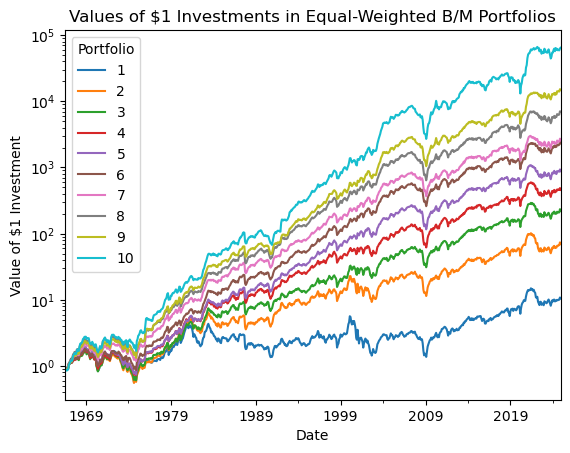

In [18]:
portfolios.add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of $1 Investment')
plt.title('Values of $1 Investments in Equal-Weighted B/M Portfolios')
plt.show()

#### Backtest the strategy

We will need the @fama1993common factors for the risk-free rate.

::: {.callout-note}
Here I set the `Date` index to simplify merges/joins below.
This is a difference from class
:::

In [19]:
ff3 = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
    .reset_index()
    .assign(Date=lambda x: x['Date'].dt.to_timestamp(how='end').dt.normalize()) # convert monthly periods to end-of-month dates
    .set_index('Date')
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20756\1889697072.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20756\1889697072.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [20]:
portfolios_rf = portfolios.sub(ff3['RF'], axis=0)

In [21]:
def CAGR(x, ann_fac=12):
    return (1 + x).prod() ** (ann_fac / x.count()) - 1

In [22]:
def Sharpe(x, ann_fac=np.sqrt(12)):
    return ann_fac * x.mean() / x.std()

In [23]:
def Volatility(x, ann_fac=np.sqrt(12)):
    return ann_fac * x.std()

In [24]:
def Drawdown(x):
    price = x.add(1).cumprod()
    return (price / price.cummax()).min() - 1

The high B/M have higher Sharper ratios and CAGRs than low B/M portfolios.
However, the risk relation is not monotonic.

In [25]:
import seaborn as sns

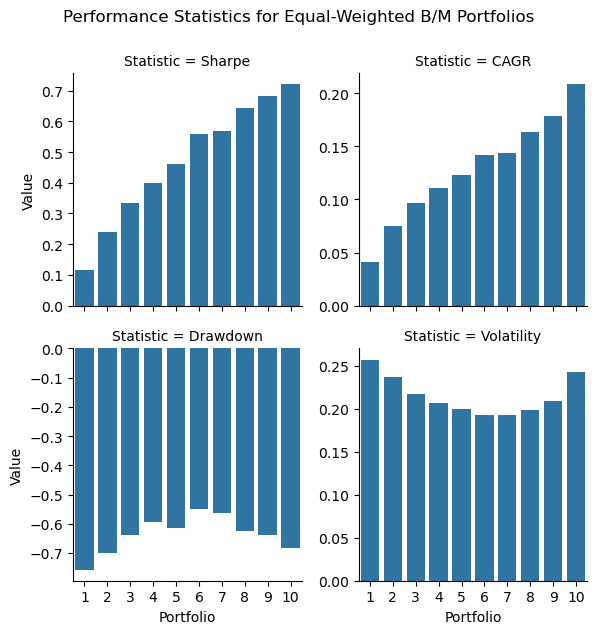

In [26]:
stats = (
    portfolios_rf
    .agg(Sharpe)
    .to_frame('Sharpe')
    .join(
        portfolios
        .agg([CAGR, Drawdown, Volatility])
        .transpose()
    )
    .rename_axis(columns='Statistic')
)

df = stats.stack().to_frame('Value').reset_index()

sns.catplot(
    data=df,
    x='Portfolio',
    y='Value',
    col='Statistic',
    col_wrap=2,
    height=3,
    kind='bar',
    sharey=False
)

plt.suptitle('Performance Statistics for Equal-Weighted B/M Portfolios', y=1.05)
plt.show()

Also, this outperformance narrows over the past few decades.

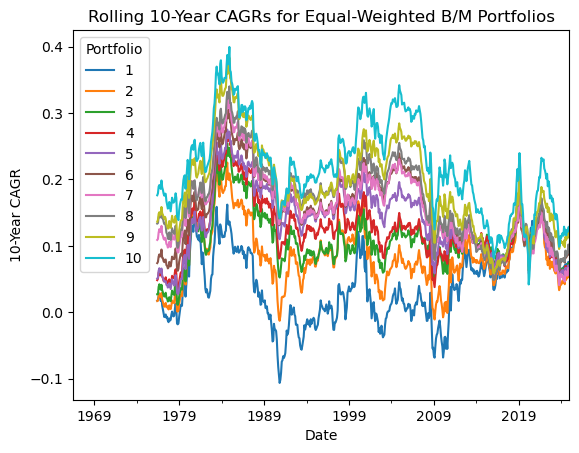

In [27]:
portfolios.rolling(window=120).apply(CAGR).plot()
plt.ylabel('10-Year CAGR')
plt.title('Rolling 10-Year CAGRs for Equal-Weighted B/M Portfolios')
plt.show()

### Re-implement the value strategy from the lecture notebook *with value-weighted portfolios*

We need to do two things:

1. Add the beginning of month market values of equity to use as portfolio weights
2. Replace `.mean()` with `np.average()` to calculate weighted means

This code prepares stock data from the `crsp` data frame by adding beginning-of-month market equity (`ME`) and merging it with portfolio assignments from the `bm` data frame.
It first selects `PERMNO`, `date`, and `RET` from `crsp`, then merges it with `ME` data shifted forward by 1 month using an inner join to align current returns with next month’s market equity.
Next, it sorts the CRSP data by `date` and `PERMNO`, and merges it with a subset of `bm` containing only `Date`, `PERMNO`, and `Portfolio`, sorted by `Date` and `PERMNO`, matching each stock’s date to the closest prior `Date` in `bm` within a 366-day tolerance.
Finally, it keeps `PERMNO`, `date`, `Portfolio`, `RET`, and `ME`, drops missing values, converts `Portfolio` to integers, and renames `date` to `Date` for consistency.

In [28]:
# Add beginning-of-month market equity (ME) to CRSP data
crsp_w_bom_me = (
    crsp
    [['PERMNO', 'date', 'RET']]                  # Select stock ID, date, and returns from CRSP
    .merge(
        right=crsp[['PERMNO', 'date', 'ME']].assign(  # Select stock ID, date, and ME, shift date to next month-end
            date=lambda x: x['date'] + pd.offsets.MonthEnd(1)),
        how='inner'                              # Inner join to align current month with next month’s ME
    )
)

# Merge CRSP data with book-to-market portfolio assignments
stocks_vw = (
    pd.merge_asof(
        left=crsp_w_bom_me.sort_values(['date', 'PERMNO']),  # Sort CRSP with ME by date and stock ID for merging
        right=bm.sort_values(['Date', 'PERMNO'])[['Date', 'PERMNO', 'Portfolio']],  # Select only Date, PERMNO, and Portfolio from BM, sort by date and stock ID
        left_on='date',                                      # Match CRSP dates to the closest prior BM date
        right_on='Date',                                     # Use BM Date as the reference for the merge
        by='PERMNO',                                         # Join on stock ID (PERMNO) to link stocks
        tolerance=pd.Timedelta('366d')                       # Limit matches to BM data within 366 days prior
    )
    [['PERMNO', 'date', 'Portfolio', 'RET', 'ME']]           # Select essential columns: stock ID, date, portfolio, returns, and ME
    .dropna()                                                # Remove rows with missing values (e.g., unmatched records)
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int))  # Convert portfolio numbers to integers for consistency
    .rename(columns={'date': 'Date'})                        # Rename 'date' to 'Date' to align with BM naming
)

This code creates value-weighted portfolios using the `stocks` data frame and reshapes the results into a wide format.
It groups the data by `Portfolio` (1 to 10) and `Date`, then calculates the value-weighted average return (`RET`) for each group, using market equity (`ME`) as weights.
Next, it pivots the data so each portfolio’s returns become separate columns, with `Date` as the index.

In [29]:
# Calculate value-weighted portfolio returns and reshape into wide format
portfolios_vw = (
    stocks_vw
    .groupby(['Portfolio', 'Date'])              # Group stocks by portfolio number (1-10) and trading date
    .apply(lambda x: np.average(a=x['RET'],      # Compute value-weighted average returns using ME as weights
                                weights=x['ME']),
           include_groups=False)                 # Exclude grouping columns (Portfolio, Date) from apply operation
    .unstack('Portfolio')                        # Pivot data so each portfolio’s returns become columns, indexed by Date
)

We can briefly compare the equal- and value-weighted portfolios.
*We see that the value effect is concentrated in small stocks because the equal-weighted portfolios returns are much larger than the value-weighted portfolio returns.*

In [30]:
df = pd.concat(
    objs=[portfolios.add(1).prod(), portfolios_vw.add(1).prod()],
    keys=['Equal', 'Value (ME)'],
    names=['Portfolio Weights'],
    axis=1
)

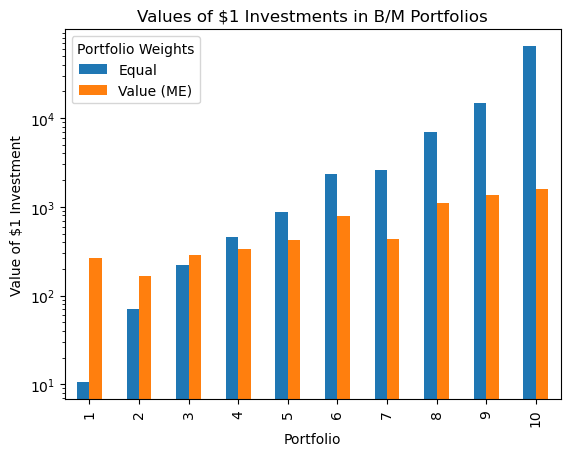

In [31]:
df.plot(kind='bar')
plt.semilogy()
plt.ylabel('Value of $1 Investment')
plt.title('Values of $1 Investments in B/M Portfolios')
plt.show()

### Estimate the $\alpha$s of the equal-weighted and value-weighted portfolios

::: {.callout-note}
Here `portfolios` is wide, so I have to `.stack()` it before the join.
This is a difference from class
:::

In [32]:
portfolios_ff3 = (
    portfolios
    .stack(future_stack=True)
    .to_frame('RET')
    .join(ff3, how='inner')
)

In [33]:
import statsmodels.formula.api as smf

***The value portfolio 10 has an $\alpha$ of 82 basis points!***
Annualized, this is $12 \times 0.0082 = 0.0984$ or almost 10% of returns not explained by market risk.

In [34]:
smf.ols(formula='I(RET-RF) ~ Q("Mkt-RF")', data=portfolios_ff3.query('(Portfolio == 10)')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            I(RET - RF)   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     717.6
Date:                Sat, 22 Mar 2025   Prob (F-statistic):          2.34e-109
Time:                        06:49:48   Log-Likelihood:                 1116.4
No. Observations:                 702   AIC:                            -2229.
Df Residuals:                     700   BIC:                            -2220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0082      0.002      4.370      0.000       0.005       0.012
Q("Mkt-RF")     1.0948      0.041     26.788      0.000       1.015       1.175
==============================================================================
Omnibus:                      268.363   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1787.450
Skew:                           1.560   Prob(JB):                         0.00
Kurtosis:                      10.167   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can plot these $\alpha$s (and confidence intervals) with list comprehensions!

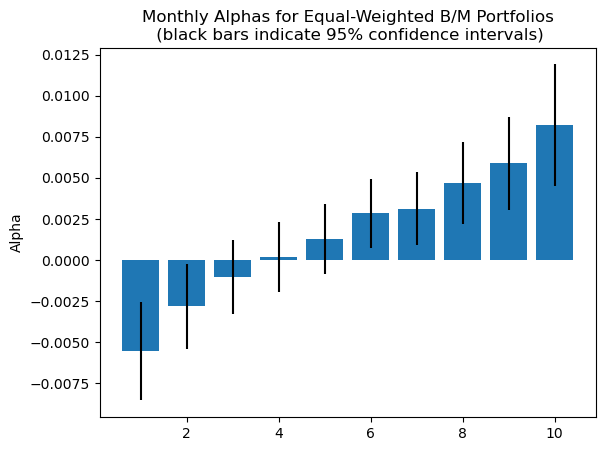

In [35]:
fits = [
    smf.ols(formula='I(RET-RF) ~ Q("Mkt-RF")', data=portfolios_ff3.query(f'(Portfolio == {p})')).fit()
    for p in range(1, 11)
]

df = (
    pd.DataFrame(
        data={
            'Alpha': [f.params['Intercept'] for f in fits],
            'Sterr': [f.bse['Intercept'] for f in fits],
            'Portfolio': range(1, 11)
        }
    )
    .set_index('Portfolio')
)

plt.bar(
    x=df.index,
    height=df['Alpha'],
    yerr=df['Sterr'].mul(1.96)
)
plt.ylabel('Alpha')
plt.title('Monthly Alphas for Equal-Weighted B/M Portfolios\n (black bars indicate 95% confidence intervals)')
plt.show()

### Implement a momentum strategy

Form deciles on the 11-month returns from months $t-12$ to month $t-2$.

This code calculates 11-month momentum returns (`RET_11`) from 2 to 12 months prior using the `crsp` data frame and assigns portfolios based on those returns.
It sets a multi-index with `PERMNO` and `date`, selects the `RET` column, and pivots to a wide format with stocks as columns.
After sorting by date, it computes compounded returns over an 11-month rolling window using log transformations (`log1p` and `expm1`), then reshapes back to long format.
It drops rows with missing `RET_11` values, creates a DataFrame, and resets the index.
Finally, it assigns stocks to decile portfolios (1 to 10) based on `RET_11` for each date and shifts the `date` forward by 2 months to reflect the momentum strategy lag.
That is, we receive returns in month $t$ based on returns from month $t-12$ through $t-2$.

In [43]:
# Calculate 2-12 month momentum returns and assign portfolios
mom_02_12 = (
    crsp
    .set_index(['PERMNO', 'date'])              # Set multi-index with stock ID (PERMNO) and date for reshaping
    ['RET']                                     # Select the monthly returns column
    .unstack('PERMNO')                          # Pivot to wide format, with PERMNO as columns and dates as rows
    .sort_index()                               # Sort dates chronologically for consistent rolling calculation
    .pipe(np.log1p)                             # Convert returns to log scale (log(1 + r)) for compounding
    .rolling(11)                                # Apply an 11-month rolling window to prior returns
    .sum()                                      # Sum log returns over the 11-month window
    .pipe(np.expm1)                             # Convert summed log returns back to compounded returns (exp(r) - 1)
    .stack(future_stack=True)                   # Reshape to long format, aligning with pandas>=2.1 stacking behavior
    .dropna()                                   # Remove rows with NaN from incomplete windows or missing data
    .to_frame('RET_11')                         # Create a DataFrame, naming the momentum returns as RET_11
    .reset_index()                              # Move PERMNO and date back to columns from the index
    .assign(
        Portfolio=lambda x: x.groupby('date')['RET_11'].transform(  # Assign stocks to decile portfolios
            lambda x: 1 + pd.qcut(x=x, q=10, labels=False)),       # Split RET_11 into 10 quantiles (0-9), shift to 1-10
        date=lambda x: x['date'] + pd.offsets.MonthEnd(2)          # Shift dates forward 2 months for momentum lag
    )
)

In [44]:
mom_02_12.head()

,date,PERMNO,RET_11,Portfolio
0,1966-01-31,10006,0.1508,5
1,1966-01-31,10014,0.2000,6
2,1966-01-31,10030,0.1489,5
3,1966-01-31,10057,0.4666,8
4,1966-01-31,10102,0.3503,7


In [45]:
stocks = (
    pd.merge(
        left=crsp, 
        right=mom_02_12, 
        on=['PERMNO', 'date'], 
        how='inner'
    )
    [['PERMNO', 'date', 'Portfolio', 'RET']]
    .dropna()
    .rename(columns={'date': 'Date'})
)

In [46]:
portfolios = (
    stocks
    .groupby(['Portfolio', 'Date'])  # Group stocks by portfolio number (1-10) and trading date
    [['RET']]                        # Isolate the returns column for portfolio-level aggregation
    .mean()                          # Average returns across stocks within each portfolio-date group (equal-weighted)
    .unstack('Portfolio')            # Pivot the data to create columns for each portfolio’s returns, indexed by date
    ['RET']                          # Extract the returns data, retaining portfolio numbers as column headers
)

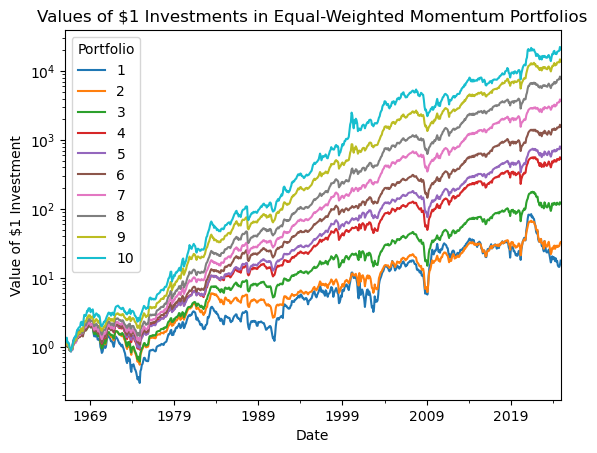

In [47]:
portfolios.add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of $1 Investment')
plt.title('Values of $1 Investments in Equal-Weighted Momentum Portfolios')
plt.show()

In [48]:
portfolios_rf = portfolios.sub(ff3['RF'], axis=0)

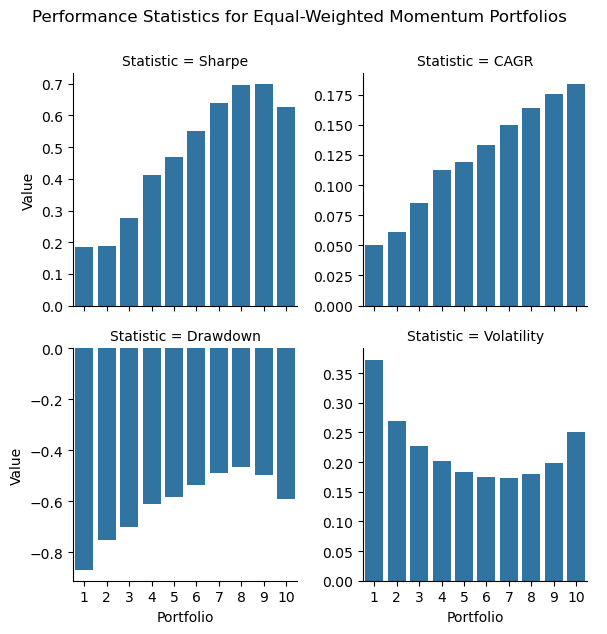

In [49]:
stats = (
    portfolios_rf
    .agg(Sharpe)
    .to_frame('Sharpe')
    .join(
        portfolios
        .agg([CAGR, Drawdown, Volatility])
        .transpose()
    )
    .rename_axis(columns='Statistic')
)

df = stats.stack().to_frame('Value').reset_index()

sns.catplot(
    data=df,
    x='Portfolio',
    y='Value',
    col='Statistic',
    col_wrap=2,
    height=3,
    kind='bar',
    sharey=False
)

plt.suptitle('Performance Statistics for Equal-Weighted Momentum Portfolios', y=1.05)
plt.show()